In [84]:
import pandas as pd
import numpy as np
import torch
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, accuracy_score

import networkx as nx

In [2]:
fraudTrain = pd.read_csv("~/Desktop/fraudTrain.csv").iloc[:,1:]
fraudTrain = fraudTrain.assign(trans_date_trans_time= list(map(lambda x: pd.to_datetime(x), fraudTrain.trans_date_trans_time)))
fraudTrain

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:00,2.703190e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:00,6.304230e+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:00,3.885950e+13,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:00,3.534090e+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:00,3.755340e+14,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2020-03-10 16:07:00,6.011980e+15,fraud_Fadel Inc,health_fitness,77.00,Haley,Wagner,F,05561 Farrell Crescent,Annapolis,...,39.0305,-76.5515,92106,"Accountant, chartered certified",1943-05-28,45ecd198c65e81e597db22e8d2ef7361,1362931649,38.779464,-76.317042,0
1048571,2020-03-10 16:07:00,4.839040e+15,"fraud_Cremin, Hamill and Reichel",misc_pos,116.94,Meredith,Campbell,F,043 Hanson Turnpike,Hedrick,...,41.1826,-92.3097,1583,Geochemist,1999-06-28,c00ce51c6ebb7657474a77b9e0b51f34,1362931670,41.400318,-92.726724,0
1048572,2020-03-10 16:08:00,5.718440e+11,"fraud_O'Connell, Botsford and Hand",home,21.27,Susan,Mills,F,005 Cody Estates,Louisville,...,38.2507,-85.7476,736284,Engineering geologist,1952-04-02,17c9dc8b2a6449ca2473726346e58e6c,1362931711,37.293339,-84.798122,0
1048573,2020-03-10 16:08:00,4.646850e+18,fraud_Thompson-Gleason,health_fitness,9.52,Julia,Bell,F,576 House Crossroad,West Sayville,...,40.7320,-73.1000,4056,Film/video editor,1990-06-25,5ca650881b48a6a38754f841c23b77ab,1362931718,39.773077,-72.213209,0


# 함수 만들기

ref: https://guebin.github.io/PP2023/posts/01_PythonBasic/2023-04-05-5wk-2.html

https://guebin.github.io/PP2023/posts/Appendix/2022-06-14-final.html#%EA%B0%80%EC%9C%84-%EB%B0%94%EC%9C%84-%EB%B3%B4-%ED%95%98%EB%82%98%EB%B9%BC%EA%B8%B0-150%EC%A0%90

```python
Class Metting0115:   
    def throw(df, fraud_rate):  # 사기 거래 비율에 맞춰 버려지는 함수!
        df1 = df[df['is_fraud'] == 1].copy()
        df0 = df[df['is_fraud'] == 0].copy()
        df0_downsample = (len(df1) * (1-fraud_rate)) / (len(df0) * fraud_rate)
        df0_down = df0.sample(frac=df0_downsample, random_state=42)
        df_p = pd.concat([df1, df0_down])
        return df_p
    
    def split_dataframe(data_frame, test_fraud_rate, test_rate=0.3):
        n = len(data_frame)
    
        # 사기 거래와 정상 거래를 분리
        fraud_data = data_frame[data_frame['is_fraud'] == 1]
        normal_data = data_frame[data_frame['is_fraud'] == 0]

        # 테스트 데이터 크기 계산
        test_samples = int(test_fraud_rate * (n * test_rate))
        remaining_test_samples = int(n * test_rate) - test_samples
    
        # 사기 거래 및 정상 거래에서 무작위로 테스트 데이터 추출
        test_fraud_data = fraud_data.sample(n=test_samples, replace=False)
        test_normal_data = normal_data.sample(n=remaining_test_samples, replace=False)

        # 테스트 데이터 합치기
        test_data = pd.concat([test_normal_data, test_fraud_data])

        # 훈련 데이터 생성
        train_data = data_frame[~data_frame.index.isin(test_data.index)]

        return train_data, test_data
    
    def concat(df_tr, df_tst):   
        df = pd.concat([df_tr, df_tst])
        train_mask = np.concatenate((np.full(len(df_tr), True), np.full(len(df_tst), False)))    # index꼬이는거 방지하기 위해서? ★ (이거,, 훔,,?(
        test_mask =  np.concatenate((np.full(len(df_tr), False), np.full(len(df_tst), True))) 
        mask = (train_mask, test_mask)
        return df, mask
        
    def evaluation(y, yhat):
        metrics = [sklearn.metrics.accuracy_score,
                   sklearn.metrics.precision_score,
                   sklearn.metrics.recall_score,
                   sklearn.metrics.f1_score,
                   sklearn.metrics.roc_auc_score]
        return pd.DataFrame({m.__name__:[m(y,yhat).round(6)] for m in metrics})
        
    def generate_w(self): ★★ ... 
        
    def bipartite(df, node_1, node_2, graph_type=nx.Graph()):
        df=df.copy()
        mapping={x:node_id for node_id, x in enumerate(set(df[node_1].values.tolist()+\
                                                          df[node_2].values.tolist()))}
    
        df["from"]=df[node_1].apply(lambda x:mapping[x])  #엣지의 출발점
        df["to"]=df[node_2].apply(lambda x:mapping[x])  #엣지의 도착점
    
        df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from','to']).agg({"is_fraud":"sum","amt":"sum"}).reset_index()
        df["is_fraud"]=df["is_fraud"].apply(lambda x:1 if x>0 else 0)
    
        G=nx.from_edgelist(df[["from","to"]].values, create_using=graph_type)
    
        nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, "label")   
        nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["amt"] for idx,x in df[["from","to","amt"]].iterrows()}, "weight") 

        return G
        
    def tripartite(df, node_1, node_2,  graph_type=nx.Graph()):
        df=df.copy()
        mapping={x:node_id for node_id, x in enumerate(set(df.index.values.tolist() + 
                                                           df[node_1].values.tolist() +
                                                           df[node_2].values.tolist()))}
        df["in_node"]= df[node_1].apply(lambda x: mapping[x])
        df["out_node"]=df[node_2].apply(lambda x:mapping[x])
    
        
        G=nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +\
                            [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], create_using=graph_type)
    
        nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")     
        nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")   
        nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")  
        nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")

        return G
        
        
        
```

## throw

In [3]:
def throw(df, fraud_rate):  # 사기 거래 비율에 맞춰 버려지는 함수!
    df1 = df[df['is_fraud'] == 1].copy()
    df0 = df[df['is_fraud'] == 0].copy()
    df0_downsample = (len(df1) * (1-fraud_rate)) / (len(df0) * fraud_rate)
    df0_down = df0.sample(frac=df0_downsample, random_state=42)
    df_p = pd.concat([df1, df0_down])
    return df_p

In [4]:
df = throw(fraudTrain, 0.5)

In [5]:
df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
2449,2019-01-02 01:06:00,4.613310e+12,fraud_Rutherford-Mertz,grocery_pos,281.06,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,...,35.9946,-81.7266,885,Soil scientist,1988-09-15,e8a81877ae9a0a7f883e15cb39dc4022,1325466397,36.430124,-81.179483,1
2472,2019-01-02 01:47:00,3.401870e+14,"fraud_Jenkins, Hauck and Friesen",gas_transport,11.52,Misty,Hart,F,27954 Hall Mill Suite 575,San Antonio,...,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,bc7d41c41103877b03232f03f1f8d3f5,1325468849,29.819364,-99.142791,1
2523,2019-01-02 03:05:00,3.401870e+14,fraud_Goodwin-Nitzsche,grocery_pos,276.31,Misty,Hart,F,27954 Hall Mill Suite 575,San Antonio,...,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,b98f12f4168391b2203238813df5aa8c,1325473523,29.273085,-98.836360,1
2546,2019-01-02 03:38:00,4.613310e+12,fraud_Erdman-Kertzmann,gas_transport,7.03,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,...,35.9946,-81.7266,885,Soil scientist,1988-09-15,397894a5c4c02e3c61c784001f0f14e4,1325475483,35.909292,-82.091010,1
2553,2019-01-02 03:55:00,3.401870e+14,fraud_Koepp-Parker,grocery_pos,275.73,Misty,Hart,F,27954 Hall Mill Suite 575,San Antonio,...,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,7863235a750d73a244c07f1fb7f0185a,1325476547,29.786426,-98.683410,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490138,2019-08-02 14:26:00,2.242540e+15,fraud_Kerluke-Abshire,shopping_net,226.12,Samuel,Jenkins,M,43235 Mckenzie Views Apt. 837,Westport,...,38.4921,-85.4524,564,Pensions consultant,1996-04-10,7f7585873fbe12b0aab9dc95ba3cecab,1343917615,37.706700,-85.806080,0
658275,2019-10-07 07:50:00,2.131640e+14,fraud_Erdman-Kertzmann,gas_transport,71.13,Mark,Tyler,M,82201 Bradley Radial Suite 703,Avera,...,33.1410,-82.5150,741,Claims inspector/assessor,1986-04-28,305f6d8297b81a36f7e57e10c1036451,1349596244,33.359566,-82.730195,0
767052,2019-11-24 15:38:00,4.464460e+12,"fraud_Ritchie, Oberbrunner and Cremin",travel,2.00,Breanna,Rodriguez,F,118 Cabrera Springs Apt. 105,Lanark Village,...,29.8826,-84.5964,217,Television production assistant,1990-01-24,3fcaef8c9a2e3654b51eb0b0b84ff424,1353771522,29.239729,-84.247963,0
234186,2019-04-28 06:15:00,5.020130e+11,fraud_Kassulke PLC,shopping_net,202.12,Sherry,Martinez,F,144 Yu Locks Apt. 754,Garrattsville,...,42.6315,-75.1866,165,Naval architect,1945-09-20,dc14c572855f13df2e55e6e844b2dd89,1335593704,43.461382,-75.910293,0


## split_dataframe

In [6]:
def split_dataframe(data_frame, test_fraud_rate, test_rate=0.3):
    n = len(data_frame)
    
    # 사기 거래와 정상 거래를 분리
    fraud_data = data_frame[data_frame['is_fraud'] == 1]
    normal_data = data_frame[data_frame['is_fraud'] == 0]

    # 테스트 데이터 크기 계산
    test_samples = int(test_fraud_rate * (n * test_rate))
    remaining_test_samples = int(n * test_rate) - test_samples

    # 사기 거래 및 정상 거래에서 무작위로 테스트 데이터 추출
    test_fraud_data = fraud_data.sample(n=test_samples, replace=False)
    test_normal_data = normal_data.sample(n=remaining_test_samples, replace=False)

    # 테스트 데이터 합치기
    test_data = pd.concat([test_normal_data, test_fraud_data])

    # 훈련 데이터 생성
    train_data = data_frame[~data_frame.index.isin(test_data.index)]

    return train_data, test_data

In [7]:
df_tr, df_ts = split_dataframe(df, 0.3)

In [8]:
df_tr.is_fraud.mean(), df_ts.is_fraud.mean()

(0.5856820073730526, 0.3000277546489037)

In [9]:
len(df_tr)/len(df), len(df_ts)/len(df)

(0.7000499500499501, 0.2999500499500499)

# concat

In [10]:
df_tr.shape, df_ts.shape

((8409, 22), (3603, 22))

In [11]:
def concat(df_tr, df_tst):  
    df = pd.concat([df_tr, df_tst])
    train_mask = np.concatenate((np.full(len(df_tr), True), np.full(len(df_tst), False)))    # index꼬이는거 방지하기 위해서?
    test_mask =  np.concatenate((np.full(len(df_tr), False), np.full(len(df_tst), True))) 
    mask = (train_mask, test_mask)
    return df, mask

`-` 예시

In [12]:
df, mask = concat(df_tr, df_ts)

In [13]:
mask

(array([ True,  True,  True, ..., False, False, False]),
 array([False, False, False, ...,  True,  True,  True]))

In [14]:
mask[1].sum()

3603

# evaluation

In [15]:
def evaluation(y, yhat):
    metrics = [sklearn.metrics.accuracy_score,
               sklearn.metrics.precision_score,
               sklearn.metrics.recall_score,
               sklearn.metrics.f1_score,
               sklearn.metrics.roc_auc_score]
    return pd.DataFrame({m.__name__:[m(y,yhat).round(6)] for m in metrics})

`-` 예시

In [16]:
y = [1, 0, 1, 1, 0, 1, 0, 0]
yhat = [1, 0, 1, 0, 1, 1, 0, 1]


In [17]:
evaluation(y,yhat)

,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0,0.625,0.6,0.75,0.666667,0.625


# generate_w

In [18]:
def generate_w(df, r, time):
    
    
    
    
    return W

- 입력: df, unique_col, theta, gamma ---> 출력: edge_index_select

In [163]:

def compute_time_difference(group):
    n = len(group)
    result = []
    for i in range(n):
        for j in range(n):
            time_difference = abs(group.iloc[i].trans_date_trans_time.value - group.iloc[j].trans_date_trans_time.value)
            result.append([group.iloc[i].name, group.iloc[j].name, time_difference])
    return result


def edge_index(df, unique_col, theta, gamma, hms='s'):
    groups = df.groupby(unique_col)
    edge_index = np.array([item for sublist in (compute_time_difference(group) for _, group in groups) for item in sublist])
    edge_index = edge_index.astype(np.float64)
    #filename = f"edge_index{str(unique_col).replace(' ', '').replace('_', '')}.npy"  # 저장
    #np.save(filename, edge_index)
    #tetha = edge_index_plust_itme[:,].mean()
    
    # compute_time_difference로 계산한 시간 차이의 value값은 total_seconds()에 10**9가 곱해져 있음
#     if hms == 's':
#         hms = 1e9
#     elif hms == 'm':
#         hms = 1e9 * 60
#     elif hms == 'h':
#         hms = 1e9 * 3600
        
    edge_index[:,2] = (np.exp(-edge_index[:,2]/theta) != 1)*(np.exp(-edge_index[:,2]/theta)).tolist()
    edge_index = torch.tensor([(int(row[0]), int(row[1])) for row in edge_index if row[2] > gamma], dtype=torch.long).t()
    return edge_index

In [158]:
a = edge_index(df, 'cc_num', 7902291948085730, 0.5)

In [159]:
a

tensor([[102490, 102490, 102490,  ..., 713531, 713531, 713531],
        [102556, 106627, 106751,  ..., 668302, 714377, 713269]])

In [160]:
a.shape

torch.Size([2, 94602])

In [165]:
abc

array([[         102490,          102490,               0],
       [         102490,          102556,   4200000000000],
       [         102490,          106627, 160680000000000],
       ...,
       [         713531,          714377,  44100000000000],
       [         713531,          713269,  12840000000000],
       [         713531,          713531,               0]])

In [170]:
hms = 1e9

In [221]:
def compute_time_difference2(group):
    n = len(group)
    result = []
    for i in range(n):
        for j in range(n):
            time_difference = abs((group.iloc[i].trans_date_trans_time - group.iloc[j].trans_date_trans_time).total_seconds())
            result.append([group.iloc[i].name, group.iloc[j].name, time_difference])
    return result
def edge_index2(df, unique_col, theta, gamma, hms='s'):
    groups = df.groupby(unique_col)
    edge_index = np.array([item for sublist in (compute_time_difference2(group) for _, group in groups) for item in sublist])
    edge_index = edge_index.astype(np.float64)
    #filename = f"edge_index{str(unique_col).replace(' ', '').replace('_', '')}.npy"  # 저장
    #np.save(filename, edge_index)
    #tetha = edge_index_plust_itme[:,].mean()
    
        
    edge_index[:,2] = (np.exp(-edge_index[:,2]/(theta)) != 1)*(np.exp(-edge_index[:,2]/(theta))).tolist()
    edge_index = torch.tensor([(int(row[0]), int(row[1])) for row in edge_index if row[2] > gamma], dtype=torch.long).t()
    return edge_index

theta의 값과 gamma의 값을 어떻게 지정해줘야할지 애매한 것 같다.
theta의 값은 초를 기준으로 되어있는데 theta의 값을 지정해줄때 a < theta < b 어떤게 나을까? 이게 어려운듯 
gamma가 일단 0~1 사이면 좋겠는데, 이건 theta가 어떻게 나눠지는지에 따라 달라지는 느낌이다

In [193]:
edge_index2(df, 'cc_num', 360000, 0.5)

tensor([[102490, 102490, 102490,  ..., 713531, 713531, 713531],
        [102556, 106627, 106751,  ..., 715096, 714377, 713269]])

In [181]:
groups = df.groupby('cc_num')
edge_index23 = np.array([item for sublist in (compute_time_difference2(group) for _, group in groups) for item in sublist])

`-` 흠

In [222]:
edge_index23

array([[102490., 102490.,      0.],
       [102490., 102556.,   4200.],
       [102490., 106627., 160680.],
       ...,
       [713531., 714377.,  44100.],
       [713531., 713269.,  12840.],
       [713531., 713531.,      0.]])

In [223]:
edge_index23[:,2].mean(),edge_index23[:,2].min(),edge_index23[:,2].max()

(7902291.9480857365, 0.0, 37504440.0)

In [228]:
pd.Series(edge_index23[:,2]).describe()

count    1.998680e+05
mean     7.902292e+06
std      9.031054e+06
min      0.000000e+00
25%      8.028000e+04
50%      4.420650e+06
75%      1.398522e+07
max      3.750444e+07
dtype: float64

(array([7.5852e+04, 5.1860e+03, 5.0100e+03, 4.6740e+03, 4.9040e+03,
        4.7600e+03, 4.9400e+03, 4.6240e+03, 4.3700e+03, 3.9460e+03,
        4.1920e+03, 3.8920e+03, 4.0500e+03, 3.6260e+03, 3.8000e+03,
        3.4080e+03, 3.6720e+03, 2.9040e+03, 3.1040e+03, 3.5940e+03,
        3.0760e+03, 3.0220e+03, 2.6960e+03, 3.2780e+03, 2.8220e+03,
        2.6280e+03, 2.3980e+03, 1.8960e+03, 2.4660e+03, 2.0780e+03,
        1.9700e+03, 1.8020e+03, 1.7960e+03, 1.4880e+03, 1.8780e+03,
        1.6200e+03, 1.3940e+03, 1.2180e+03, 1.1420e+03, 7.9000e+02,
        9.3400e+02, 6.6200e+02, 5.0200e+02, 4.6200e+02, 3.9600e+02,
        3.8800e+02, 2.4200e+02, 1.7400e+02, 1.1600e+02, 2.6000e+01]),
 array([       0.        ,   750088.8       ,  1500177.6       ,
         2250266.4       ,  3000355.2       ,  3750444.        ,
         4500532.8       ,  5250621.6       ,  6000710.4       ,
         6750799.2       ,  7500888.        ,  8250976.8       ,
         9001065.6       ,  9751154.4       , 10501243.2  

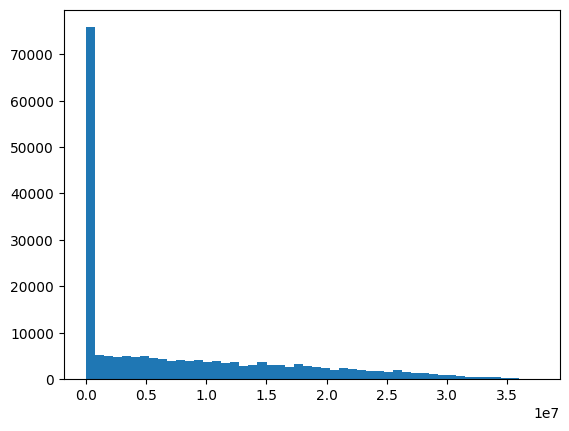

In [191]:
import matplotlib.pyplot as plt

plt.hist(edge_index23[:, 2], bins=50)


<< 이렇게 몰려있는데.. 1e7이라서 흠... tehta=뭘로 주는게 올바른? 적절한 건지 잘 모르겠음.. 

# bipartite

In [327]:
def bipartite(df, node_1, node_2, graph_type=nx.Graph()):
    df=df.copy()
    mapping={x:node_id for node_id, x in enumerate(set(df[node_1].values.tolist()+\
                                                      df[node_2].values.tolist()))}
    
    df["from"]=df[node_1].apply(lambda x:mapping[x])  #엣지의 출발점
    df["to"]=df[node_2].apply(lambda x:mapping[x])  #엣지의 도착점
    
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from','to']).agg({"is_fraud":"sum","amt":"sum"}).reset_index()
    df["is_fraud"]=df["is_fraud"].apply(lambda x:1 if x>0 else 0)
    
    G=nx.from_edgelist(df[["from","to"]].values, create_using=graph_type)
    
    nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, "label")   
    nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["amt"] for idx,x in df[["from","to","amt"]].iterrows()}, "weight") 

    return G


    
    

In [356]:
G  = bipartite(df, node_1 = 'cc_num', node_2 = 'merchant')

# tripartite

In [330]:

def tripartite(df, node_1, node_2,  graph_type=nx.Graph()):
    df=df.copy()
    mapping={x:node_id for node_id, x in enumerate(set(df.index.values.tolist() + 
                                                       df[node_1].values.tolist() +
                                                       df[node_2].values.tolist()))}
    df["in_node"]= df[node_1].apply(lambda x: mapping[x])
    df["out_node"]=df[node_2].apply(lambda x:mapping[x])
    
        
    G=nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +\
                        [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], create_using=graph_type)
    
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")     
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")   
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")  
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")

    return G

In [355]:
G = tripartite(df, 'cc_num', 'merchant')

불균형 데이터 
tr/ts
1. 오토글루온
2. pyod
3. tripartite + auto
4. proposed(gnn)

4 > 3 > 2 > 1 이 되어야한당..

학회
균형데이터 
tr/s
1. 오토글루온
2. bibpartite(이상쓰...)
3. proposed

# G_split

In [363]:


def G_split(G, test_size):
    train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G.edges))), 
                                                                      list(nx.get_edge_attributes(G, "label").values()), 
                                                                      test_size=test_size, 
                                                                      random_state=42)
    edgs = list(G.edges)
    
    train_graph = G.edge_subgraph([edgs[x] for x in train_edges]).copy()
    train_graph.add_nodes_from(list(set(G.nodes) - set(train_graph.nodes)))
    test_graph = G.edge_subgraph([edgs[x] for x in test_edges]).copy()
    test_graph.add_nodes_from(list(set(G.nodes) - set(test_graph.nodes)))
    
    return train_graph, test_graph

In [364]:
train_graph, test_graph = G_split(G, test_size=0.2)

In [ ]:
G_

In [362]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

node2vec_train = Node2Vec(G_split(G,0.2), weight_key='weight')
model_train = node2vec_train.fit(window=10)

Computing transition probabilities:   0%|          | 0/1629 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
